In [1]:
%load_ext autoreload
%autoreload 2

main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os

p = Pipeline(working_folder=f'{main_path}/Snapshots/1')

p.add_node(LoaderNode, None, 'train',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_train.csv'
           })
p.add_node(LoaderNode, None, 'test',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_test.csv'
           })
p.run()

def mix_train_test(dfs):
    df_train, df_test = dfs
    df_train['orderid'] = df_train['orderid'] + 1000000
    df_train = df_train.set_index('orderid')
    df_test = df_test.set_index('orderid')
    data = pd.concat([df_train, df_test], axis=0, sort=False )
    data.fillna(-1,inplace=True)
    return data

p.add_node(FunctionNode, ('train','test'),'data',
           params={
               'function': mix_train_test
           })
p.run()

p.add_node(EraserNode, params={
    'remove_keys': ['train', 'test']
})
p.run()

def set_categorical_features(df):
    cat_fields = ['field12', 'field26', 'field27', 'field29']
    for f in cat_fields:
        df[f] = pd.Categorical(df[f])
    return df

p.add_node(FunctionNode, 'data','data',
           params={
               'function': set_categorical_features
           })
p.run()

---------------------------
0: LoaderNode [2020-01-03 19:32:40]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_train.csv'}
---------------------------
1: LoaderNode [2020-01-03 19:32:41]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_test.csv'}
---------------------------
2: FunctionNode [2020-01-03 19:32:42]
params:
 {'function': <function mix_train_test at 0x0000014903BCAF28>}
---------------------------
3: EraserNode [2020-01-03 19:32:43]
params:
 {'remove_keys': ['train', 'test']}
---------------------------
4: FunctionNode [2020-01-03 19:32:43]
params:
 {'function': <function set_categorical_features at 0x000001491AA79F28>}


In [2]:
df = p.data['data']

In [101]:
tr = df[df['goal1'] != -1]
te = df[df['goal1'] == -1]
to_drop = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25']
tr.drop(to_drop, axis=1, inplace=True)
te.drop(to_drop, axis=1, inplace=True)

del df
gc.collect()

stuff = ['userid', 'goal1']

cats = []
for col in tr.columns:
    if tr[col].dtype.name in ['category', 'object']:
        cats.append(col)

# Outliers Tukey

In [92]:
def outliers_tukey(df, cols, k):
    '''
    outlier detection via Tukey's method (k*interquartile range)
    :param df: dataframe
    :param cols: featues to count
    :param k: coefficient 1.5 indicates outlier, 3 - far out
    :return:
    '''
    outliers = pd.DataFrame()

    for idx, col in enumerate(cols):
        lower_quartile = df[[col]].describe().loc['25%', col]
        upper_quartile = df[[col]].describe().loc['75%', col]
        diff = upper_quartile - lower_quartile
        x = 0.8
        if diff == 0:
            while diff == 0:
                if x >= 1:
                    print(col, 'tukey doesnt work for this feat')
                    break
                upper_quartile = df[[col]].describe(percentiles=[0.25, x]).loc[str(int(100*x))+'%', col] 
                diff = upper_quartile - lower_quartile
                x+=0.05
                
                
        
        lower_boarder = lower_quartile - k * diff
        upper_boarder = upper_quartile + k * diff
        outliers.loc[col, 'prc'] = round(
            100 * df.loc[(df[col] < lower_boarder) | (df[col] > upper_boarder), col].count() / len(df[col]), 2)
        outliers.loc[col, 'lower_boarder'] = round(lower_boarder, 2)
        outliers.loc[col, 'upper_boarder'] = round(upper_boarder, 2)

        outliers.loc[col, 'min_value'] = df[col].min()
        outliers.loc[col, 'max_value'] = df[col].max()

    return outliers

outtr = pd.DataFrame()
outtr = outtr.append(outliers_tukey(tr, [x for x in tr.columns if x not in stuff+cats], 3))

outtr = outtr.sort_values('prc', ascending=False)
outtr

field8 tukey doesnt work for this feat
field9 tukey doesnt work for this feat


,prc,lower_boarder,upper_boarder,min_value,max_value
field0,15.050000000000001,-39.00,52.00,0.000000000000000,500.000000000000000
field8,12.060000000000000,1.00,1.00,0.000000000000000,1.000000000000000
field6,10.890000000000001,-3.00,4.00,0.000000000000000,323.000000000000000
field4,9.470000000000001,-2.00,5.00,1.000000000000000,363.000000000000000
field13,6.850000000000000,-66.00,95.00,0.000000000000000,746.000000000000000
field25,6.540000000000000,-14.00,21.00,0.000000000000000,170.000000000000000
field17,6.420000000000000,-5.00,9.00,0.000000000000000,156.000000000000000
field22,5.430000000000000,-122.00,165.00,0.000000000000000,867.000000000000000
field16,4.500000000000000,-46.00,66.00,0.000000000000000,340.000000000000000
field1,3.020000000000000,-2.33,2.01,-0.859222202084794,82.142133944666668


In [93]:
outte = pd.DataFrame()
outte = outte.append(outliers_tukey(te, [x for x in te.columns if x not in stuff+cats], 3))

outte = outte.sort_values('prc', ascending=False)
outte

field8 tukey doesnt work for this feat
field9 tukey doesnt work for this feat


,prc,lower_boarder,upper_boarder,min_value,max_value
field0,15.06,-39.00,52.00,0.000000000000000,507.000000000000000
field8,12.00,1.00,1.00,0.000000000000000,1.000000000000000
field6,10.94,-3.00,4.00,0.000000000000000,344.000000000000000
field4,9.48,-2.00,5.00,1.000000000000000,756.000000000000000
field13,6.82,-66.00,95.00,0.000000000000000,928.000000000000000
field17,6.41,-5.00,9.00,0.000000000000000,179.000000000000000
field25,6.34,-14.00,21.00,0.000000000000000,193.000000000000000
field22,5.40,-122.00,165.00,0.000000000000000,1049.000000000000000
field16,4.42,-46.00,66.00,0.000000000000000,339.000000000000000
field1,3.05,-2.33,2.01,-0.859222202084794,79.271993591928521


In [45]:
rating = pd.read_pickle('temp/rating.pkl')
rating = pd.DataFrame(rating.values(), index=rating.keys(), columns=['gini']).sort_values('gini', ascending=False)
rating

,gini
field16_to_stdscore_groupby_(field26+has_children),25.500000000000000
field16_to_stdscore_groupby_(field26+all_children),25.500000000000000
field16_to_stdscore_groupby_(field26+field27),25.500000000000000
field16_to_minmax_groupby_(field27+field6bin),25.500000000000000
field16_to_stdscore_groupby_(field27+field26),25.500000000000000
field16_to_minmax_groupby_(field26+lang_country),25.399999999999999
field16_to_minmax_groupby_(field27+field0bin),25.300000000000001
field16_to_minmax_groupby_(field26+field17bin),25.300000000000001
field16_to_std_groupby_(field27+field29),25.300000000000001
field16_to_mean_groupby_(field26+all_children),25.300000000000001


In [94]:
for col in outtr[outtr['prc'] > 1].index:
    print(tr[col].value_counts().sort_index(), '\n', te[col].value_counts().sort_index())
    print('==============================================================================')

0      126851
1        3457
2        2374
3        2063
4        1832
        ...  
489         1
491         1
495         1
496         1
500         1
Name: field0, Length: 486, dtype: int64 
 0      294371
1        8307
2        5590
3        4840
4        4246
        ...  
499         1
500         2
502         1
503         1
507         1
Name: field0, Length: 502, dtype: int64
0     23651
1    172405
Name: field8, dtype: int64 
 0     54589
1    400422
Name: field8, dtype: int64
0      152779
1        6618
2        5579
3        5623
4        4103
        ...  
275         1
279         1
297         1
298         1
323         1
Name: field6, Length: 147, dtype: int64 
 0      354858
1       15113
2       12716
3       12787
4        9741
        ...  
286         1
290         2
294         1
305         1
344         1
Name: field6, Length: 182, dtype: int64
1      113902
2       35753
3       15044
4        7987
5        4796
        ...  
359         1
360         1
361 

# gini - clipped/not clipped

In [118]:
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
def individual_gini(feat, df, y, n_jobs, silent=True):
    '''
    count individual Gini for feature
    :param feat: feature to count Gini for
    :param df: dataframe
    :param y: target series
    :param n_jobs: n_jobs
    :return: individual Gini
    '''
#     print(' feature: ', feat)

    if df[feat].dtypes == 'O':
        x = pd.get_dummies(df[feat]).values
        obvious_gini = 0
    else:
        #         print('\t  Counting obvious gini...')
#         if df[feat].dtype.name in ('float32', 'float64'):
#             df = df.fillna(-99999)
        x = np.array(df[feat].values).reshape(-1, 1)
        obvious_gini = round(abs(roc_auc_score(y, x) * 2 - 1), 3)

    #     print('\t  Now count gini using decision tree')
    parameters = {'min_weight_fraction_leaf':  [0.01, 0.025, 0.05, 0.1]}

    dt = DecisionTreeClassifier(random_state=0)
    cv = StratifiedKFold(3, random_state=0)
    clf = GridSearchCV(dt, parameters, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

#     print('\t  Run grid search...')
    clf.fit(x, y)

    true_gini = round(abs(clf.best_score_ * 2 - 1), 3)
    if silent:
        pass
    else:
        print('\t  True gini is ', true_gini)
        print('-------------------------------------------')

    return max(100 * obvious_gini, 100 * true_gini)

In [119]:
for col in [x for x in outtr.index if x not in ['field8', 'field9']]:
#     print(col)
    tr[col + '_clipped'] = tr[col].clip(outtr.loc[col]['lower_boarder'], outtr.loc[col]['upper_boarder'])
    g1 = individual_gini(col, tr, tr['goal1'], 1)
    g2 = individual_gini(col + '_clipped', tr, tr['goal1'], 1)
    print(col, g1, g2)

field0 7.3 7.3
field6 9.2 9.0
field4 6.7 6.7
field13 8.6 8.200000000000001
field25 12.5 12.3
field17 5.7 5.6000000000000005
field22 13.4 13.4
field16 25.1 25.1
field1 15.8 15.8
field14 16.1 16.0
field15 2.6 2.6
field24 2.9000000000000004 2.9000000000000004
field28 0.7000000000000001 0.7000000000000001
field11 1.7000000000000002 1.7000000000000002
field10 4.0 4.0
field7 13.5 13.5
field5 4.9 4.9
field18 1.6 1.6
field19 2.1999999999999997 2.1999999999999997
field20 0.2 0.2
field21 5.800000000000001 5.800000000000001
field3 5.2 5.2
field23 2.7 2.7
field2 6.4 6.4


In [121]:
tr['field2'].value_counts().sort_index()

1      5854
2      4999
3      5490
4      5777
5      4827
6     25113
7     29790
8     26808
9     22752
10    23578
11    22003
12    19065
Name: field2, dtype: int64

In [122]:
tr['field2_clipped'].value_counts().sort_index()

1      5854
2      4999
3      5490
4      5777
5      4827
6     25113
7     29790
8     26808
9     22752
10    23578
11    22003
12    19065
Name: field2_clipped, dtype: int64

In [124]:
outtr

,prc,lower_boarder,upper_boarder,min_value,max_value
field0,15.050000000000001,-39.00,52.00,0.000000000000000,500.000000000000000
field8,12.060000000000000,1.00,1.00,0.000000000000000,1.000000000000000
field6,10.890000000000001,-3.00,4.00,0.000000000000000,323.000000000000000
field4,9.470000000000001,-2.00,5.00,1.000000000000000,363.000000000000000
field13,6.850000000000000,-66.00,95.00,0.000000000000000,746.000000000000000
field25,6.540000000000000,-14.00,21.00,0.000000000000000,170.000000000000000
field17,6.420000000000000,-5.00,9.00,0.000000000000000,156.000000000000000
field22,5.430000000000000,-122.00,165.00,0.000000000000000,867.000000000000000
field16,4.500000000000000,-46.00,66.00,0.000000000000000,340.000000000000000
field1,3.020000000000000,-2.33,2.01,-0.859222202084794,82.142133944666668


# Кат фичи, значения которых в трейне/тесте отсутствуют

In [25]:
for col in [x for x in cats if x not in ['userid']]:
    print(col)
    print(set(tr[col].value_counts().index) - set(te[col].value_counts().index),
      set(te[col].value_counts().index) - set(tr[col].value_counts().index))

field12
set() set()
field26
set() set()
field27
set() set()
field29
set() set()


# KS

In [26]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

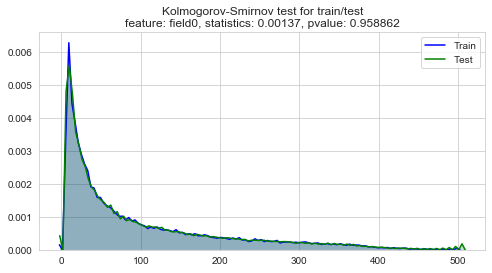

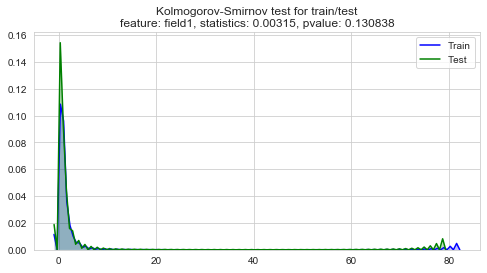

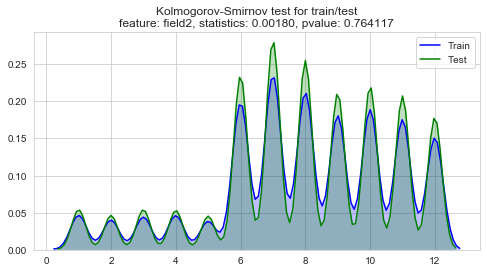

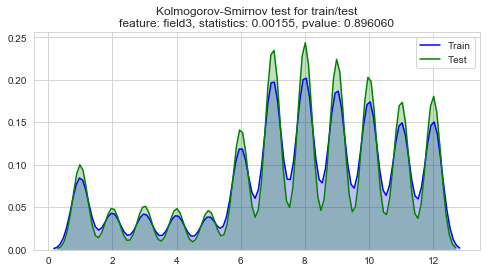

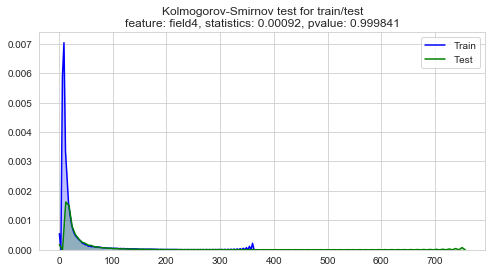

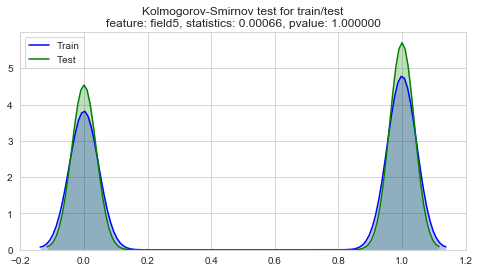

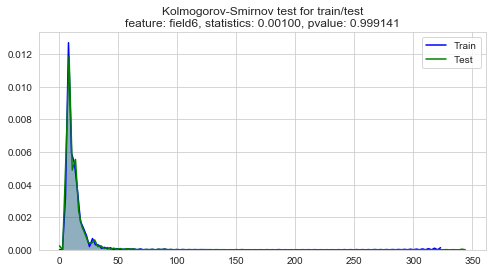

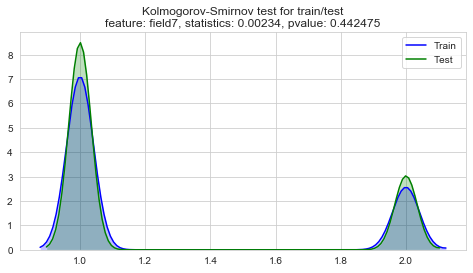

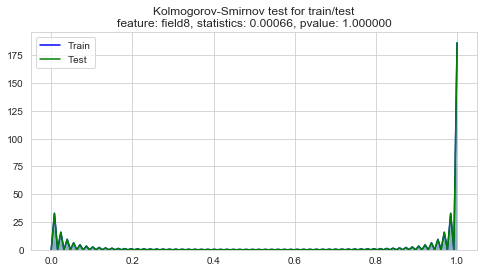

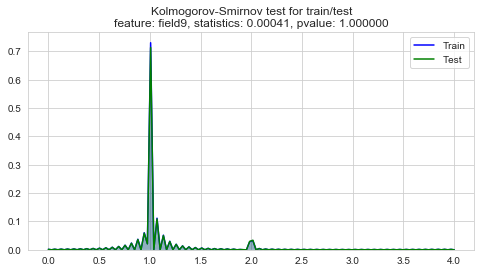

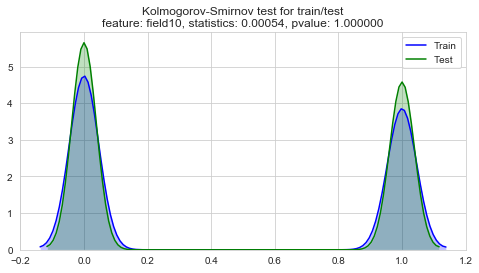

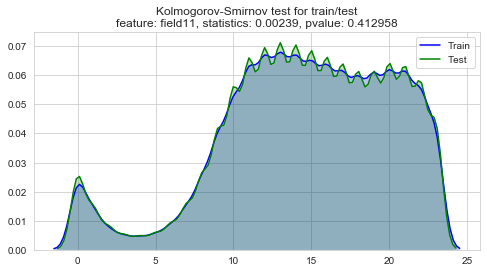

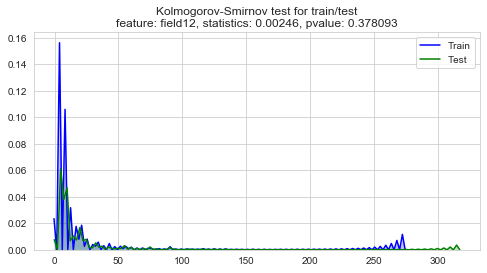

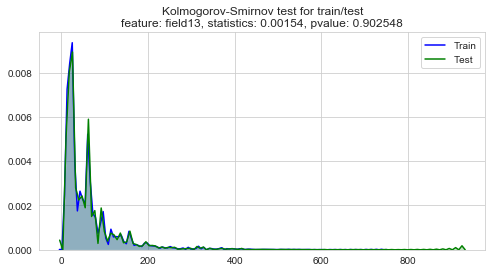

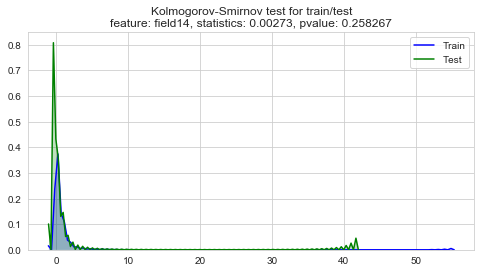

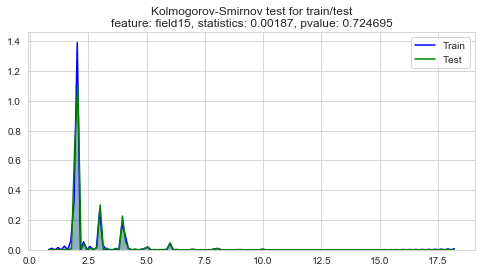

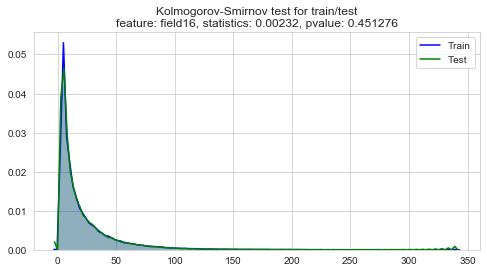

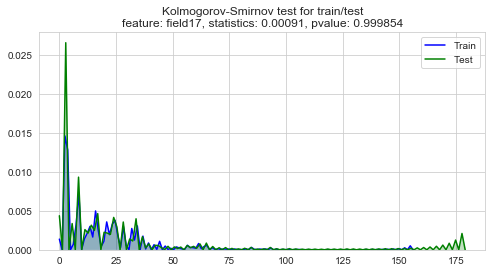

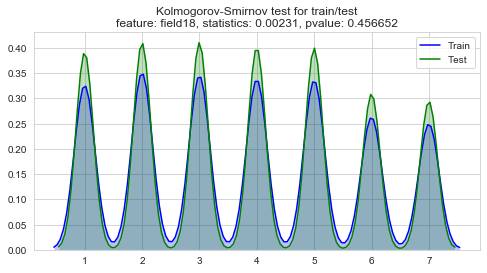

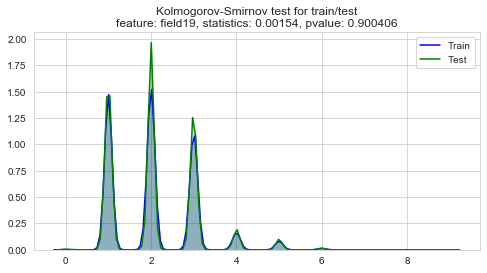

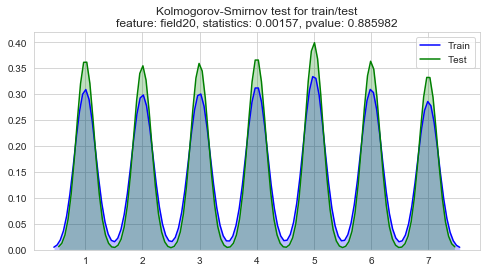

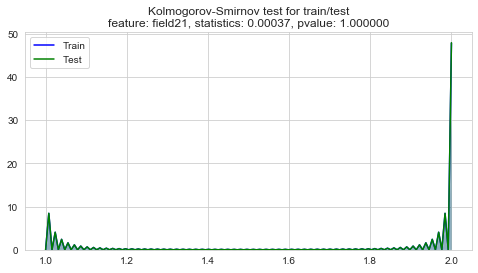

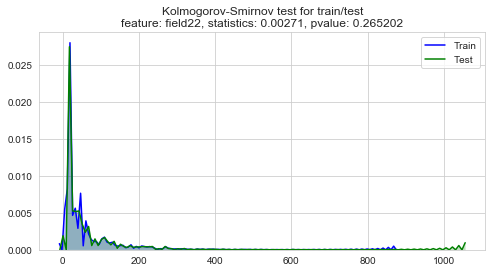

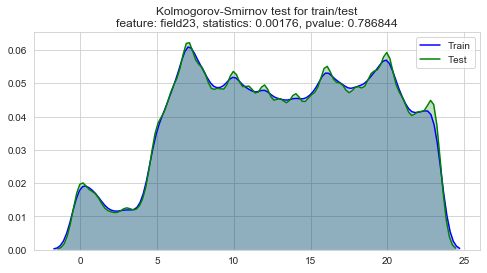

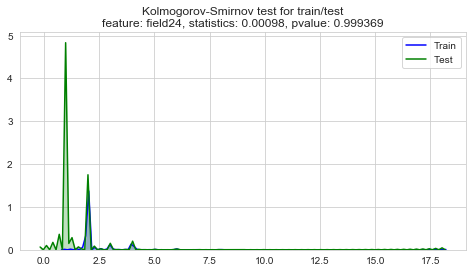

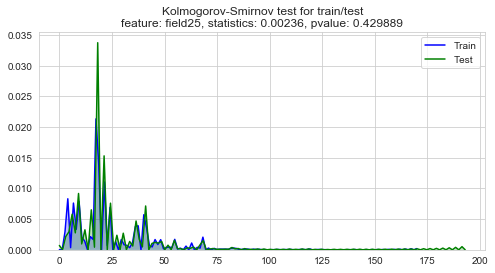

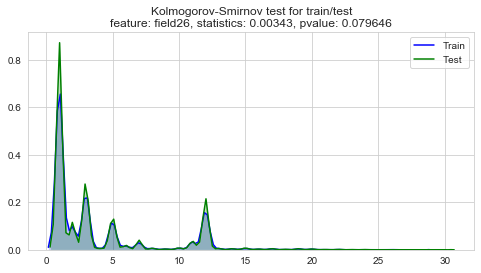

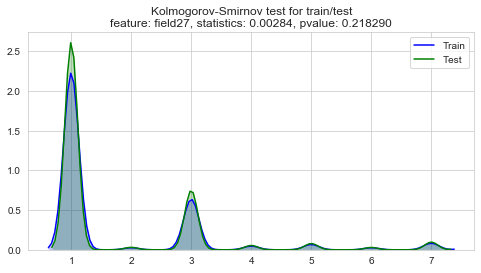

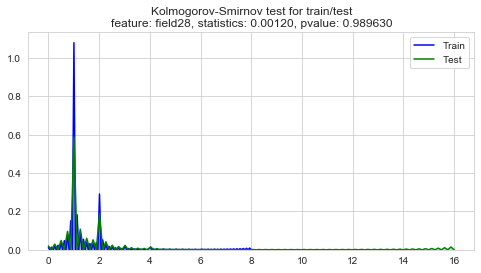

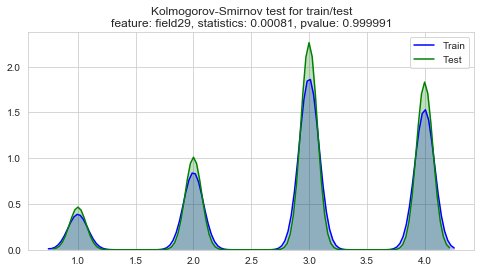

In [28]:
hypothesisnotrejected = []
hypothesisrejected = []

for col in [x for x in tr.columns if x not in stuff]:
    statistic, pvalue = ks_2samp(tr[col], te[col])
    if pvalue>=statistic:
        hypothesisnotrejected.append(col)
    if pvalue<statistic:
        hypothesisrejected.append(col)
        
    plt.figure(figsize=(8,4))
    plt.title("Kolmogorov-Smirnov test for train/test\n"
              "feature: {}, statistics: {:.5f}, pvalue: {:5f}".format(col, statistic, pvalue))
    sns.kdeplot(tr[col], color='blue', shade=True, label='Train')
    sns.kdeplot(te[col], color='green', shade=True, label='Test')

    plt.show()

In [30]:
field1 0.13
field14 0.25
field22 0.26
# filed26 0.08
# field27 0.22

[]

# newbies

In [10]:
stat = df.groupby('userid')['field1'].agg(['count']).sort_values(by='count', ascending=False)

In [16]:
newbie = df[df['userid'].isin(stat[stat['count'] == 1].index)]
oldie = df[df['userid'].isin(stat[stat['count'] != 1].index)]

In [20]:
newbie['goal1'].value_counts()

-1.0    181355
 0.0     76375
 1.0      1774
Name: goal1, dtype: int64

In [22]:
1774/(76375+1774)

0.02270022649042214

In [21]:
oldie['goal1'].value_counts()

-1.0    273656
 0.0    115340
 1.0      2567
Name: goal1, dtype: int64

In [23]:
2567/(2567+115340)

0.02177139610031635